# Examining LAMOST Kepler Gaia crossmatch.

The version of this code used in the paper is implemented in code/data.py.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

In [3]:
lamost = pd.read_csv("../data/gaia-kepler-lamost_snr.csv")  # File created using the LAMOST DR5 website: http://dr5.lamost.org/search

Merge Gaia and LAMOST catalogs using RA and dec.

In [49]:
# Load Gaia-Kepler crossmatch.
# with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
print(np.shape(gaia))
gaia = gaia.drop_duplicates(subset="source_id")
gaia = gaia.drop_duplicates(subset="kepid")
print(np.shape(gaia))

(198451, 133)
(195130, 133)


Round Gaia ra and dec down to 6 decimal places for the Xmatch.

In [5]:
gaia["ra_6dp"] = np.round(gaia.ra.values, 6)
gaia["dec_6dp"] = np.round(gaia.dec.values, 6)

In [6]:
# Add LAMOST
lamost["ra_6dp"] = lamost.inputobjs_input_ra.values
lamost["dec_6dp"] = lamost.inputobjs_input_dec.values
lamost_gaia = pd.merge(gaia, lamost, on=["ra_6dp", "dec_6dp"], how="left", suffixes=["", "_lamost"])
lamost_gaia = lamost_gaia.drop_duplicates(subset="source_id")

In [7]:
print(max(lamost_gaia.phot_g_mean_mag.values))

20.837604522705078


edr3 crossmatch:

In [27]:
# edr3 = pd.read_csv("../data/dr2edr3-result.csv")
edr3 = pd.read_csv("~/Downloads/distances_guess-result.csv")
# for k in edr3.keys():
#     print(k)

(0, 7500)

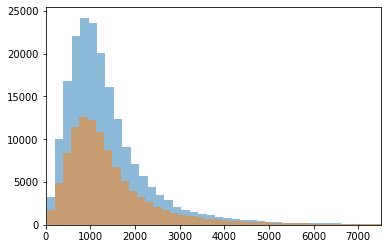

In [28]:
plt.hist(lamost_gaia.r_est, 100, alpha=.5);
plt.hist(edr3.r_med_geo, 100, alpha=.5);
plt.xlim(0, 7500)

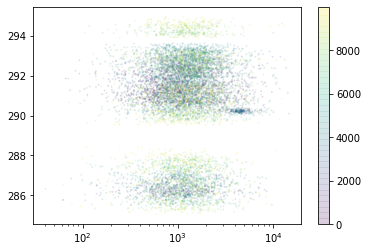

In [42]:
ran1 = np.arange(len(lamost_gaia))
m = ran1 < 10000
plt.scatter(lamost_gaia.r_est.values[m], lamost_gaia.ra.values[m], c=ran1[m], s=1, alpha=.1, rasterized=True)
plt.xscale("log")
plt.colorbar();
# ran2 = np.arange(len(edr3))

Save the Xmatched catalogue.

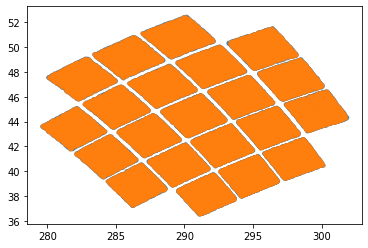

In [10]:
plt.plot(lamost_gaia.ra_6dp, lamost_gaia.dec_6dp, ".", alpha=.5)
plt.plot(edr3.ra, edr3.dec, ".", alpha=.5)

In [11]:
# for k in edr3.keys():
#     print(k)
np.shape(edr3), np.shape(lamost_gaia)

((107066, 112), (196300, 131))

101299 107066


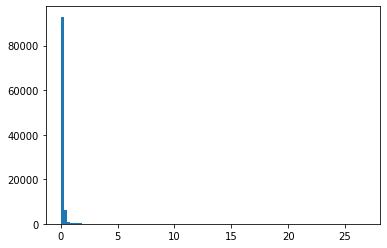

In [15]:
close = edr3.angular_distance.values < 100
print(sum(close), len(edr3))

In [33]:
m = np.isfinite(lamost_gaia.stellar_rv.values)
_m = np.isfinite(lamost_gaia.radial_velocity.values) & (lamost_gaia.radial_velocity.values != 0)
print(f"All stars = {len(lamost_gaia)}, Stars with LAMOST RVs = {sum(m)}, stars with Gaia RVs = {sum(_m)}")

All stars = 196300, Stars with LAMOST RVs = 37949, stars with Gaia RVs = 30276


In [34]:
m = np.isfinite(lamost_gaia.stellar_rv.values) & np.isfinite(lamost_gaia.radial_velocity.values) \
    & (lamost_gaia.radial_velocity.values != 0) & (abs(lamost_gaia.stellar_rv_err.values) < 100)
print(f"Stars with both Gaia and LAMOST RVS = {sum(m)}")

Stars with both Gaia and LAMOST RVS = 12418


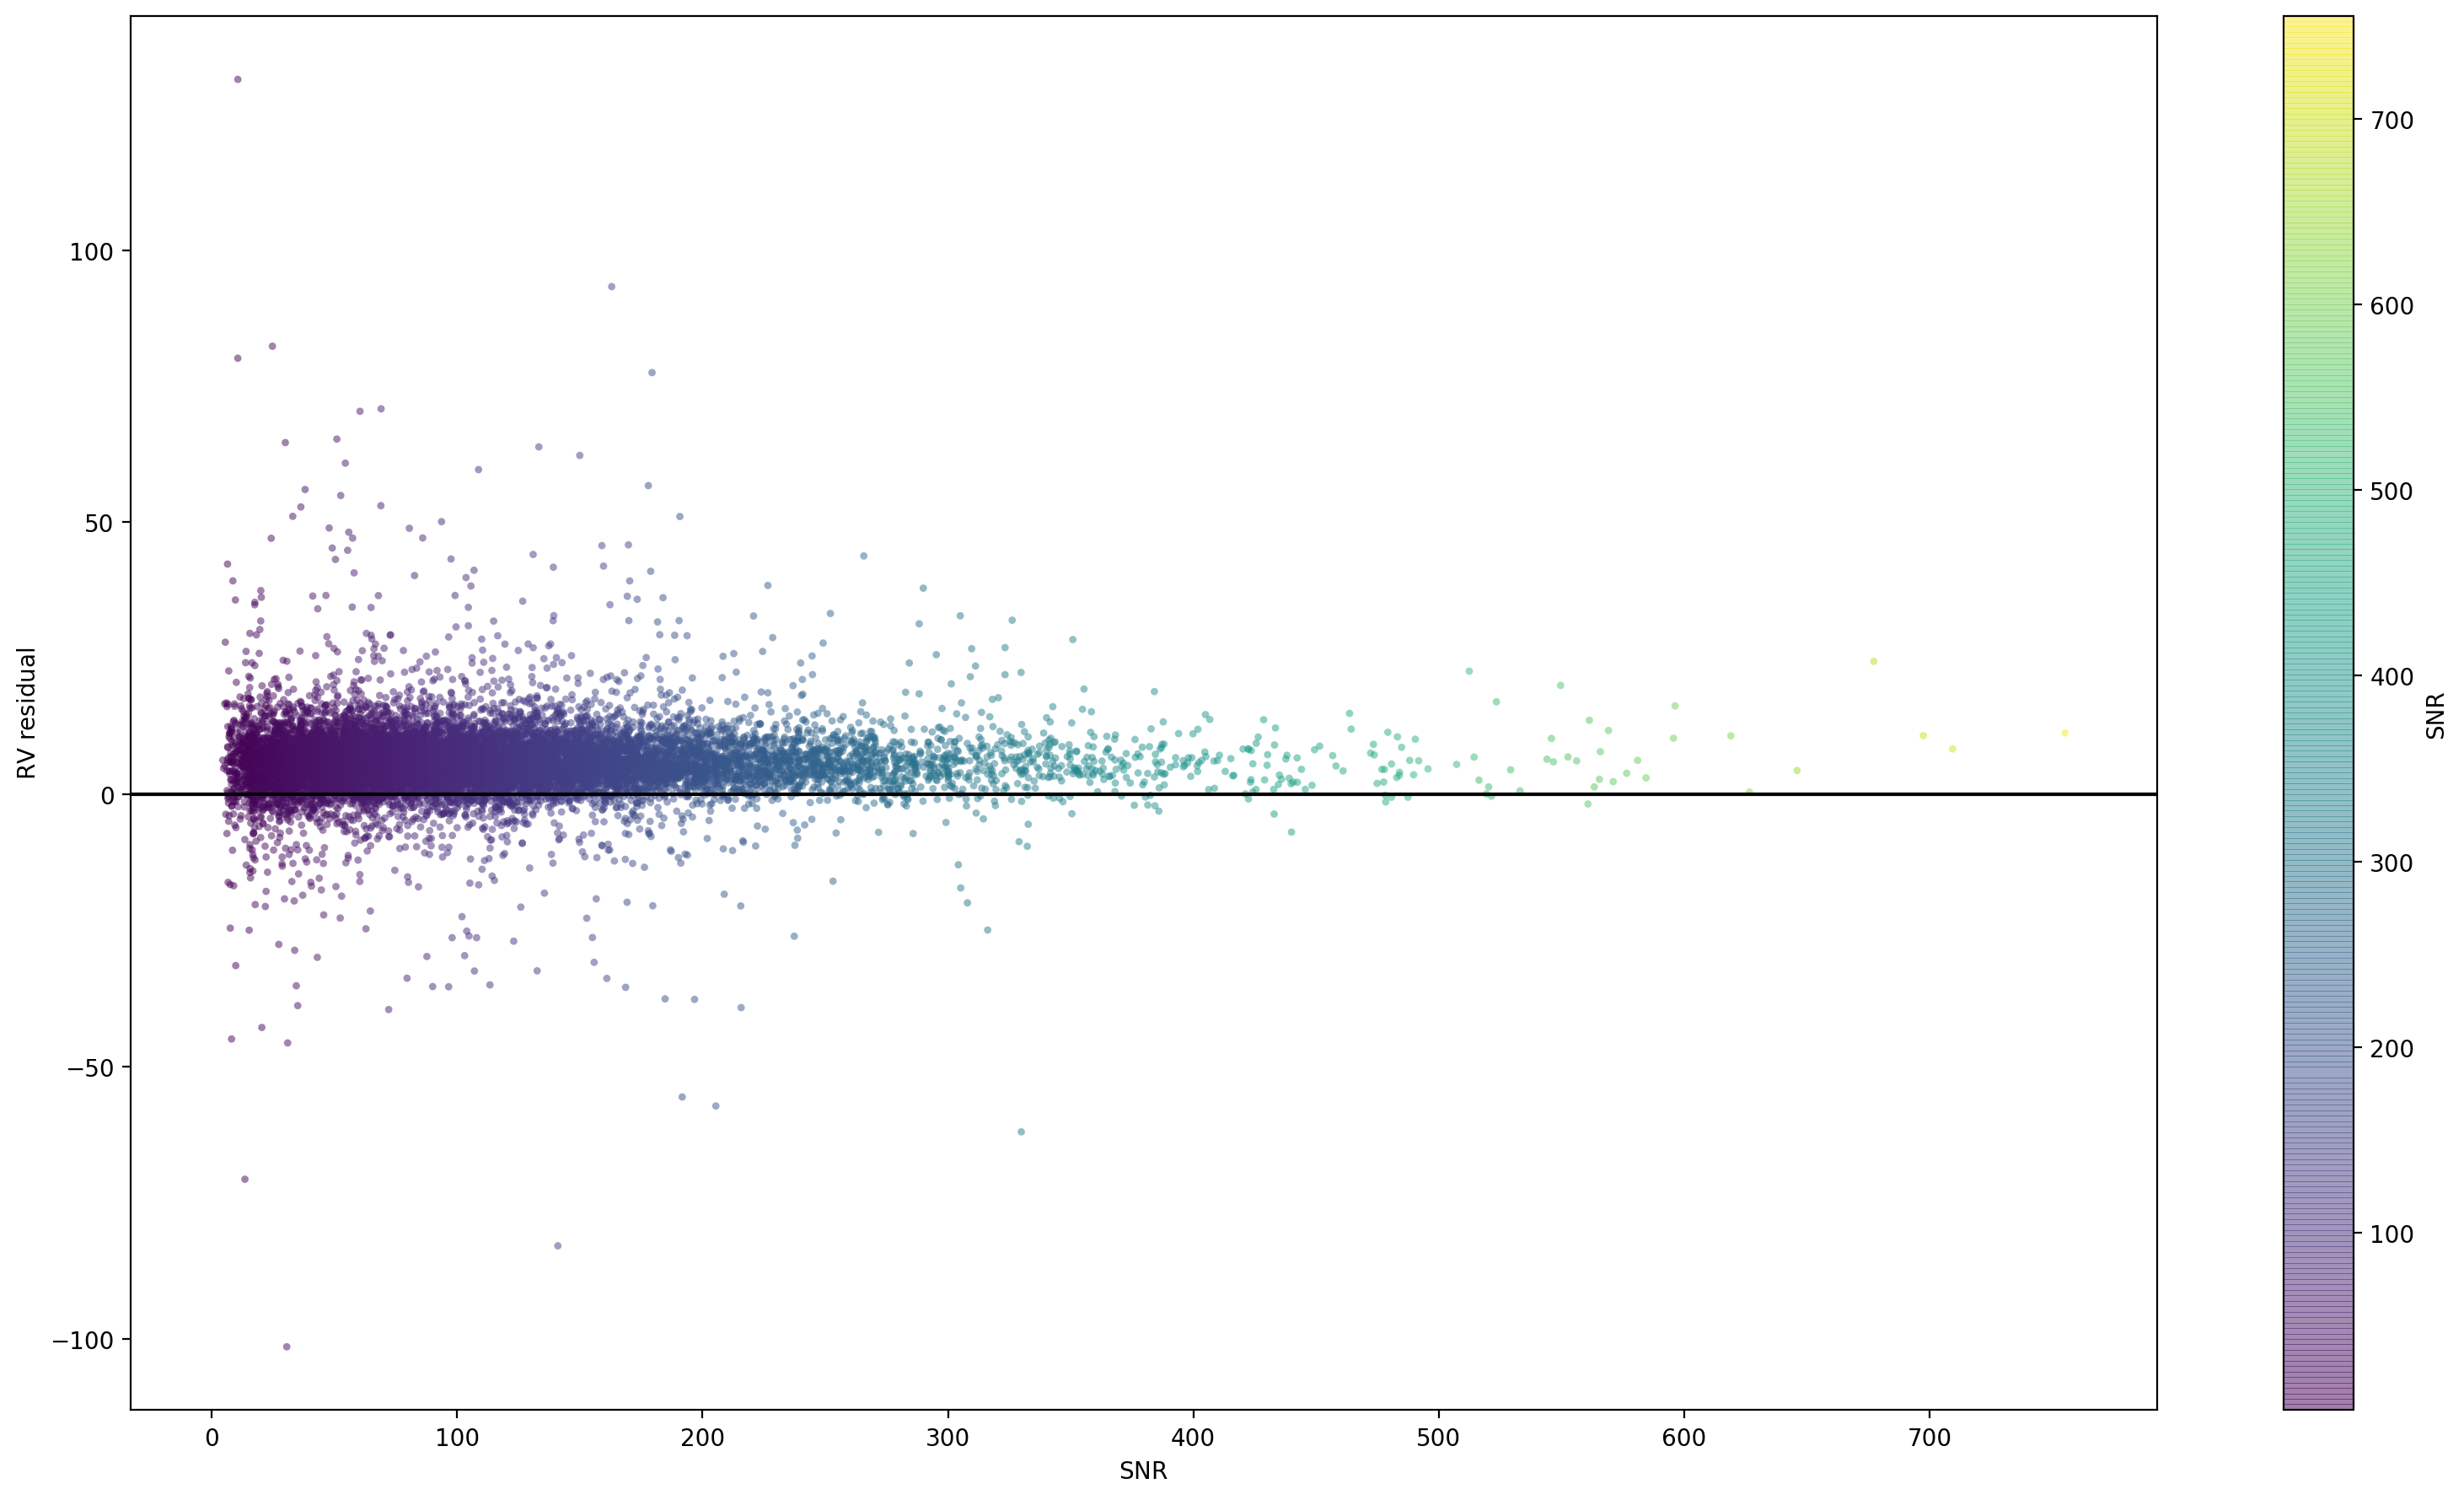

In [35]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(lamost_gaia.catalogue_snrg.values[m], lamost_gaia.radial_velocity.values[m] - lamost_gaia.stellar_rv.values[m],
            c=lamost_gaia.catalogue_snrg.values[m], s=10, alpha=.5, edgecolor="none", zorder=0, rasterized=True)
plt.axhline(0, color="k")
plt.xlabel("$\mathrm{SNR}$")
plt.ylabel("$\mathrm{RV~residual}$")
plt.colorbar(label="SNR")
plt.tight_layout()

12418


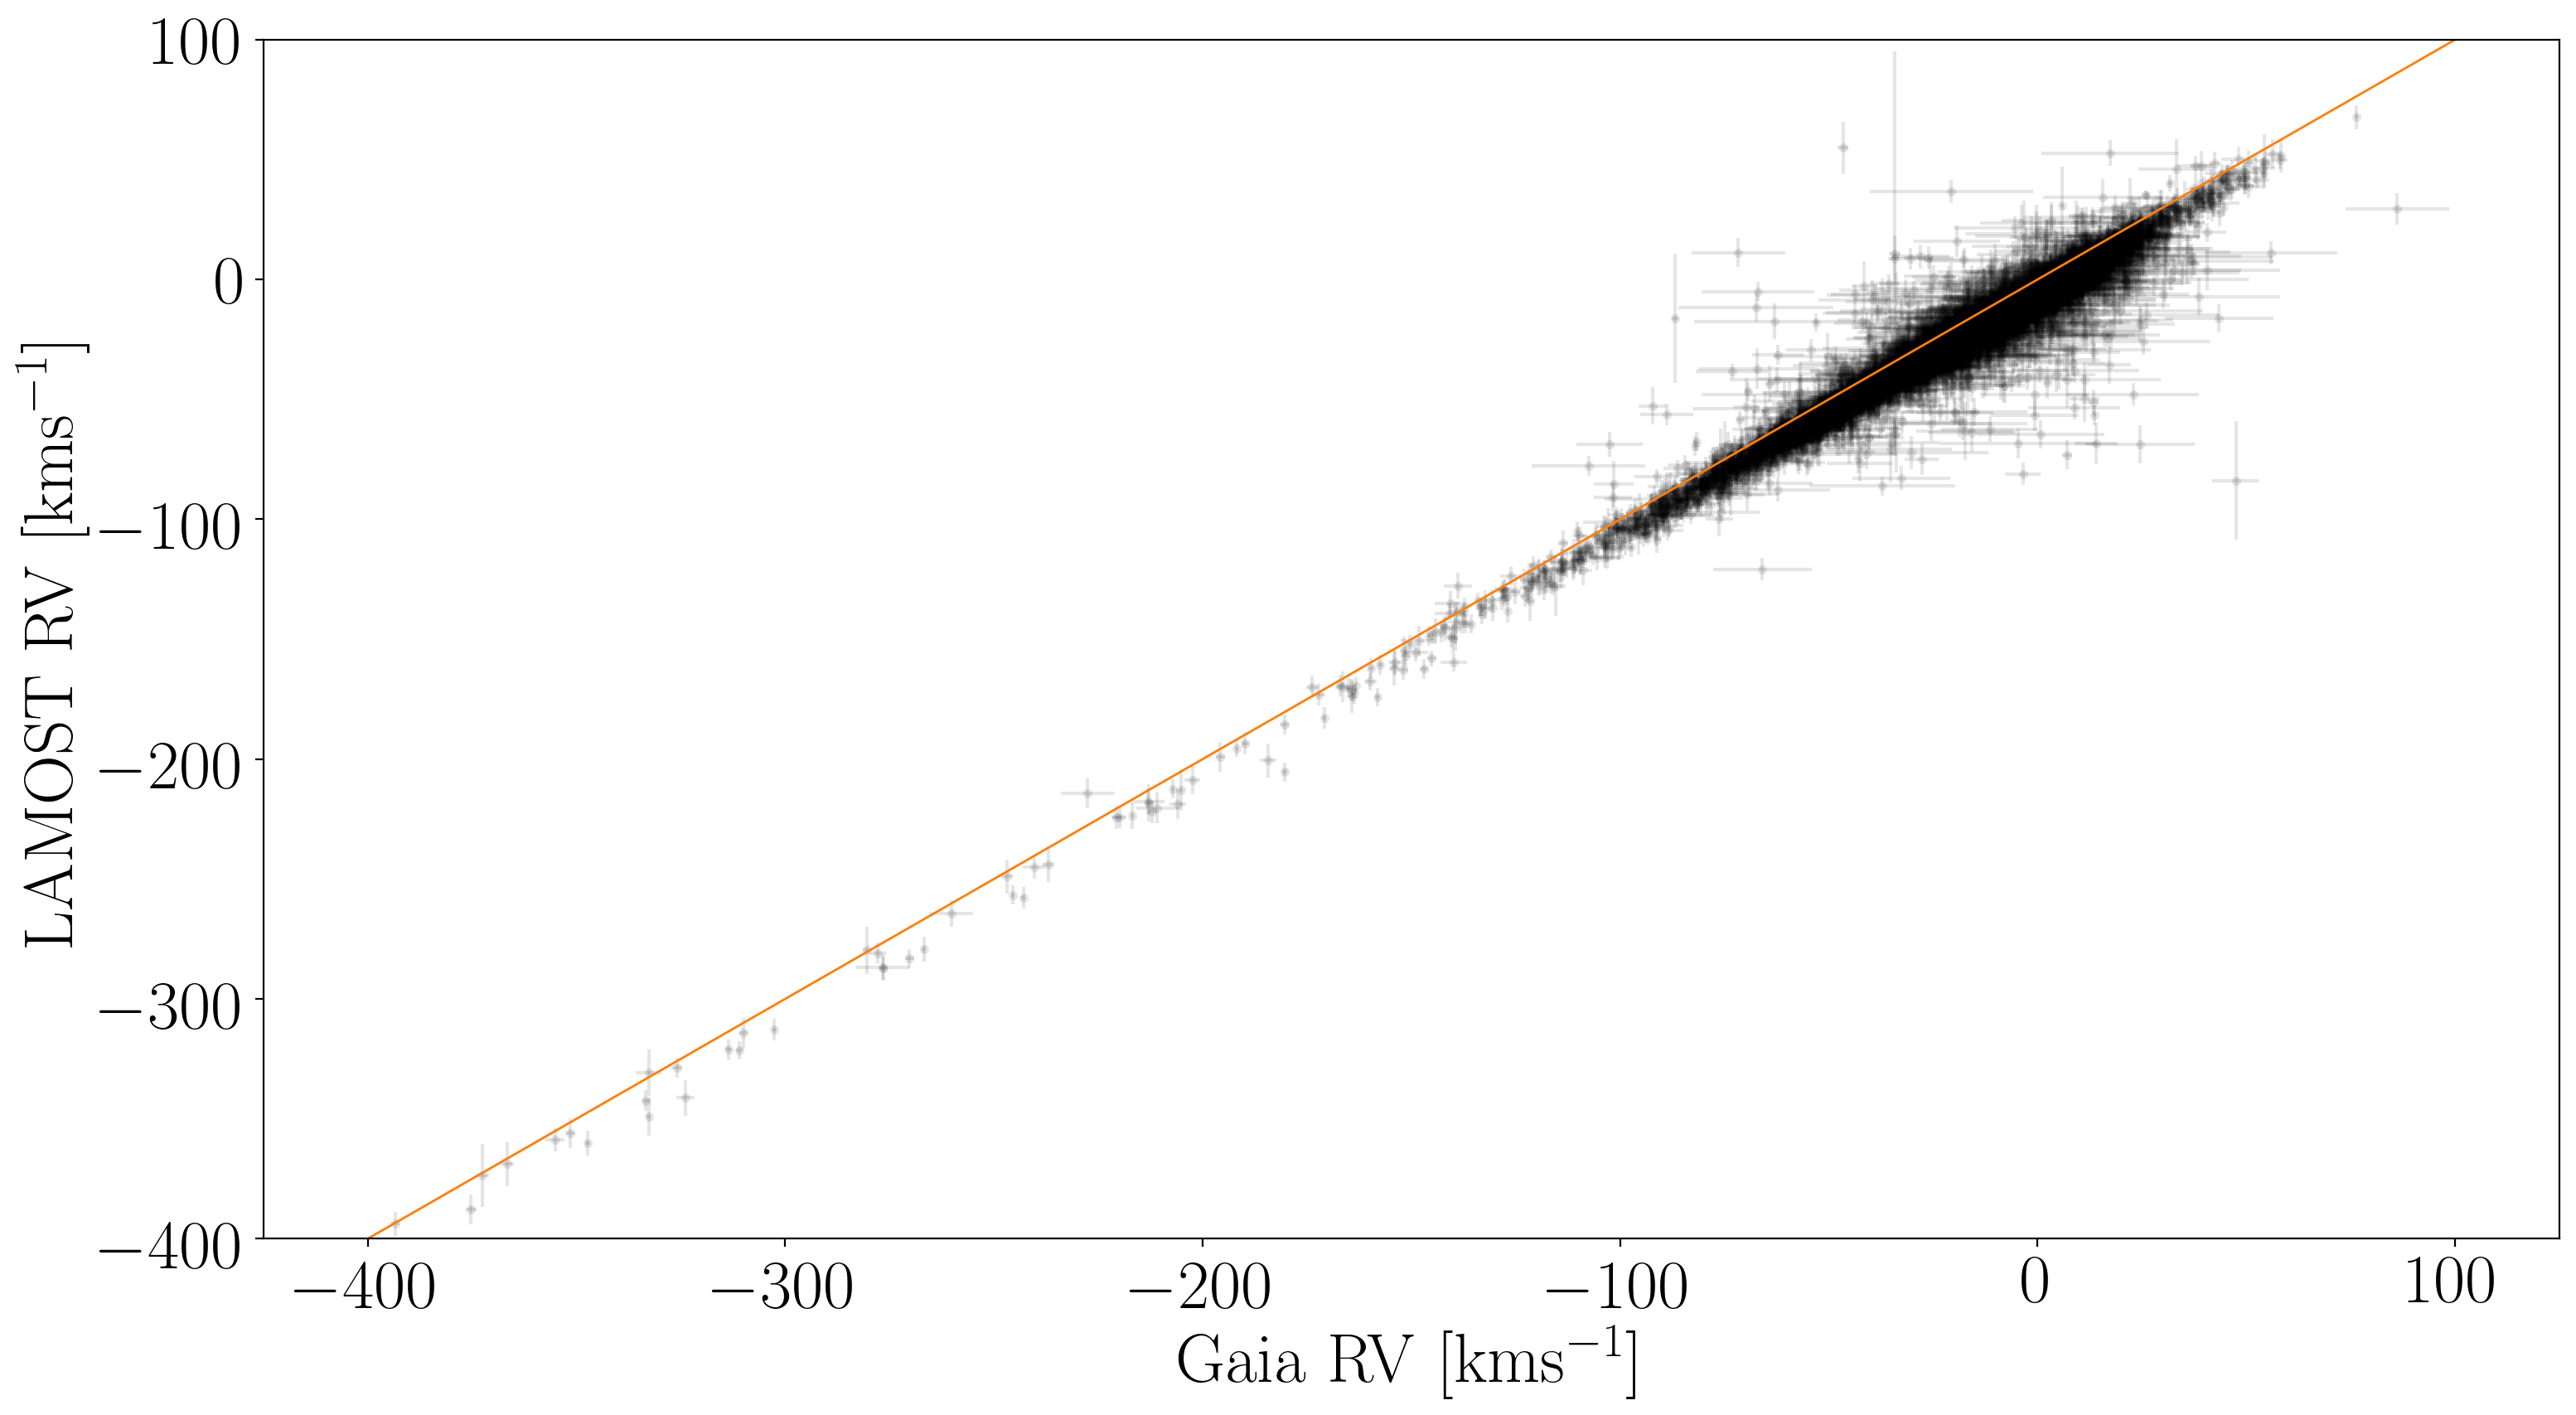

In [36]:
plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

m = np.isfinite(lamost_gaia.stellar_rv.values) & np.isfinite(lamost_gaia.radial_velocity.values) \
    & (lamost_gaia.radial_velocity.values != 0) & (abs(lamost_gaia.stellar_rv_err.values) < 100)
print(sum(m))

plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(lamost_gaia.radial_velocity.values[m], lamost_gaia.stellar_rv.values[m],
             xerr=lamost_gaia.radial_velocity_error.values[m],
             yerr=lamost_gaia.stellar_rv_err.values[m],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.xlabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.ylabel("$\mathrm{LAMOST~RV~[km s^{-1}]}$")
plt.tight_layout()
plt.savefig("../plots/lamost_gaia_rvs")
plt.savefig("../plots/lamost_gaia_rvs.pdf")

1.0859441472482947 1.2325764133053378


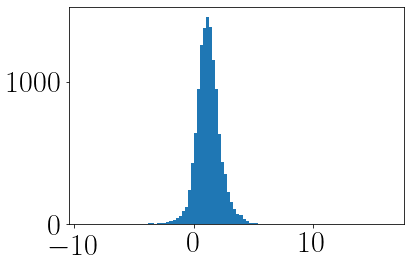

In [37]:
tot_err = np.sqrt(lamost_gaia.radial_velocity_error.values[m]**2 + lamost_gaia.stellar_rv_err.values[m]**2)
resids = lamost_gaia.radial_velocity.values[m] - lamost_gaia.stellar_rv.values[m]
plt.hist(resids/tot_err, 100);
print(np.std(resids/tot_err), np.mean(resids/tot_err))

median Gaia RV uncertainty =  1.140668114452404
median LAMOST RV uncertainty =  4.27


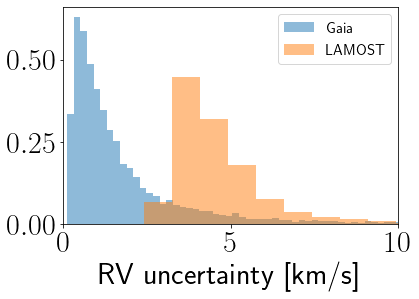

In [38]:
plt.hist(lamost_gaia.radial_velocity_error.values[m], 100, density=True, alpha=.5, label="Gaia");
plt.hist(lamost_gaia.stellar_rv_err.values[m], 100, density=True, alpha=.5, label="LAMOST");
plt.legend()
plt.xlim(0, 10)
plt.xlabel("RV uncertainty [km/s]")

print("median Gaia RV uncertainty = ", np.median(lamost_gaia.radial_velocity_error.values[m]))
print("median LAMOST RV uncertainty = ", np.median(lamost_gaia.stellar_rv_err.values[m]))

In [86]:
# Load apogee
from astropy.table import Table
tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo = tbl[names].to_pandas()

# apogee = pd.DataFrame(dict({"source_id": apo.GAIA_SOURCE_ID.values,
#                             "apogee_rv": apo.OBSVHELIO_AVG.values,
#                             "apogee_rv_err": apo.OBSVERR.values}))

apodf = pd.merge(apo, lamost_gaia, how="right", left_on="GAIA_SOURCE_ID", right_on="source_id")
apodf = apodf.drop_duplicates(subset="source_id")
print(np.shape(apogee), np.shape(lamost_gaia), np.shape(apodf))
apodf.to_csv()

(473307, 3) (196300, 131) (196300, 328)


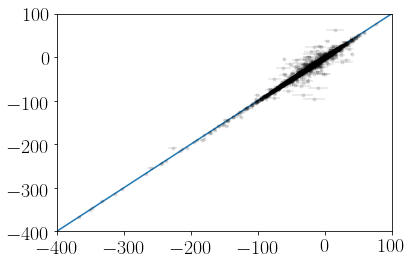

In [78]:
noz = np.isfinite(apodf.stellar_rv.values) & np.isfinite(apodf.radial_velocity.values) \
    & (apodf.radial_velocity.values != 0) & (abs(apodf.stellar_rv_err.values) < 100)

plt.errorbar(apodf.radial_velocity.values[noz], apodf.apogee_rv.values[noz],
             xerr=apodf.radial_velocity_error.values[noz], yerr=apodf.apogee_rv_err.values[noz], fmt="k.", alpha=.1)
plt.ylim(-400, 100)
plt.xlim(-400, 100)
plt.plot(xs, xs)

median Gaia RV uncertainty =  1.140668114452404
median LAMOST RV uncertainty =  4.27
median APOGEE RV uncertainty =  nan


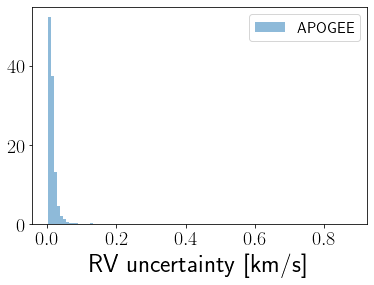

In [84]:
# plt.hist(apodf.radial_velocity_error.values[noz], 100, density=True, alpha=.5, label="Gaia");
# plt.hist(apodf.stellar_rv_err.values[noz], 100, density=True, alpha=.5, label="LAMOST");
plt.hist(apodf.apogee_rv_err.values[noz], 100, density=True, alpha=.5, label="APOGEE");
plt.legend()
# plt.xlim(0, 10)
plt.xlabel("RV uncertainty [km/s]")

print("median Gaia RV uncertainty = ", np.median(apodf.radial_velocity_error.values[noz]))
print("median LAMOST RV uncertainty = ", np.median(apodf.stellar_rv_err.values[noz]))
print("median APOGEE RV uncertainty = ", np.median(apodf.apogee_rv_err.values[noz]))

# Here's one I made earlier

Load the file output by data.py

In [62]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")
print(np.shape(df))
df = df.drop_duplicates(subset="source_id")
print(np.shape(df))

(178000, 151)
(177372, 151)
(473307, 3) (177372, 151) (177372, 153)


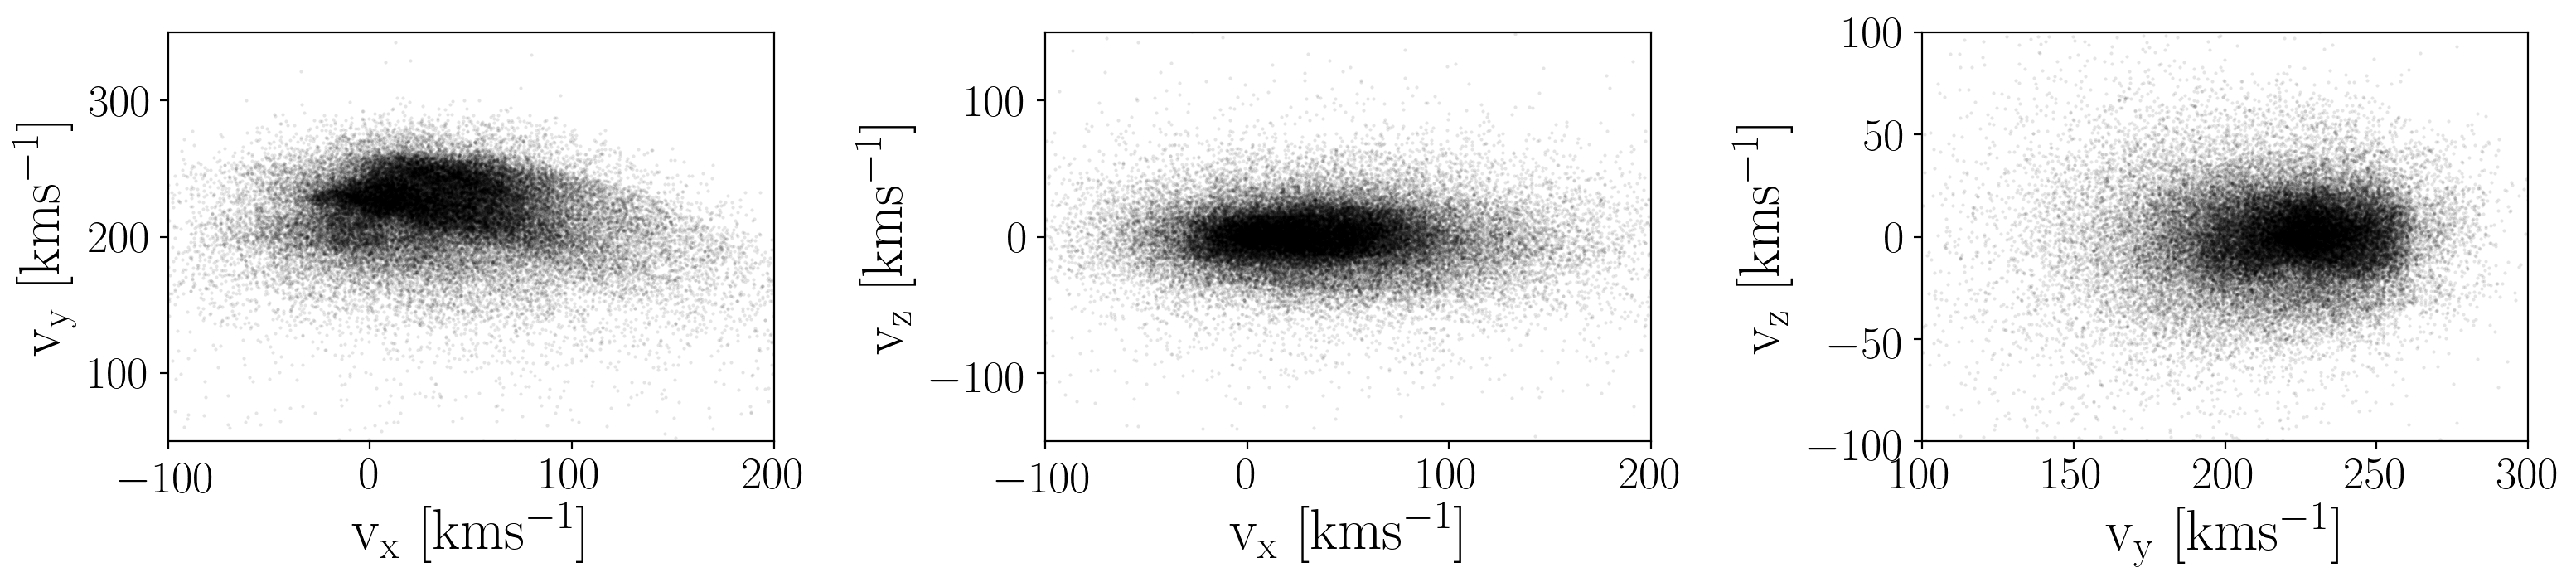

In [40]:
plotpar = {'axes.labelsize': 25,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(df.vx, df.vy, "k.", ms=1, alpha=.1, rasterized=True)
ax0.set_xlim(-100, 200)
ax0.set_ylim(50, 350)
ax0.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax0.set_ylabel("$\mathrm{v_y~[km s^{-1}]}$")

ax1 = fig.add_subplot(132)
ax1.plot(df.vx, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax1.set_xlim(-100, 200)
ax1.set_ylim(-150, 150)
ax1.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax1.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

ax2 = fig.add_subplot(133)
ax2.plot(df.vy, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax2.set_ylim(-100, 100)
ax2.set_xlim(100, 300)
ax2.set_xlabel("$\mathrm{v_y~[km s^{-1}]}$")
ax2.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

plt.tight_layout()

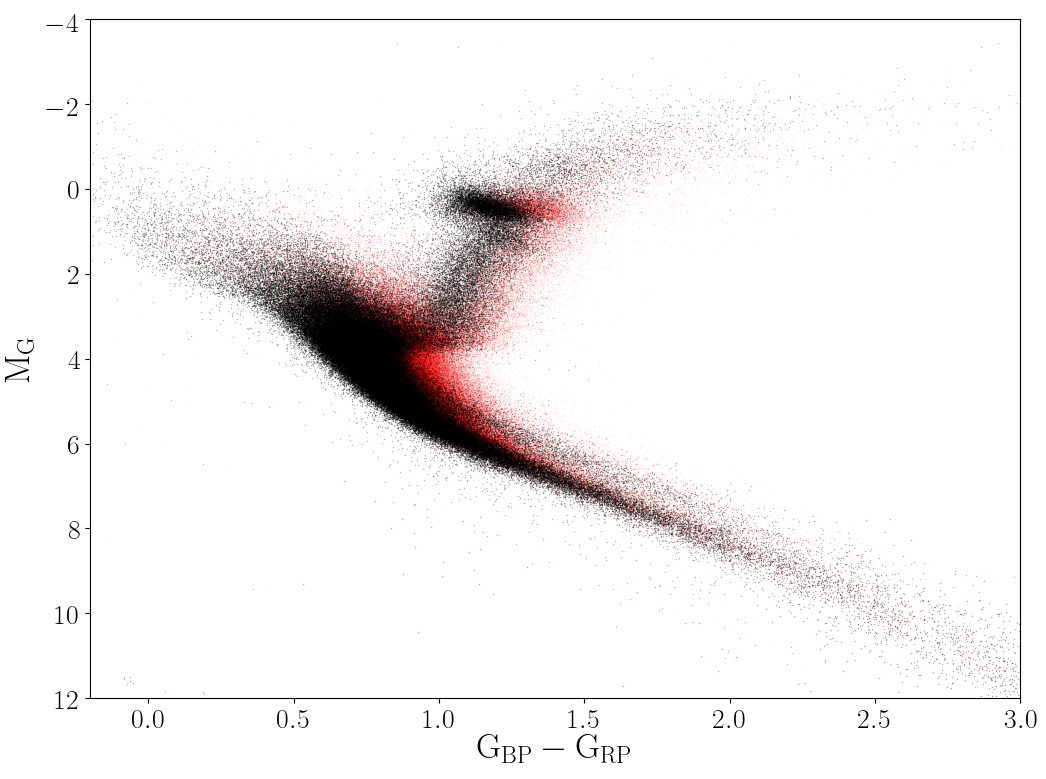

In [41]:
plt.figure(figsize=(12, 9), dpi=100)
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.abs_G, "r.", ms=2, alpha=.1, mec="none", zorder=0, rasterized=True)
plt.plot(df.bprp_dered, df.abs_G, "k.", ms=2, alpha=.3, mec="none", zorder=1)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

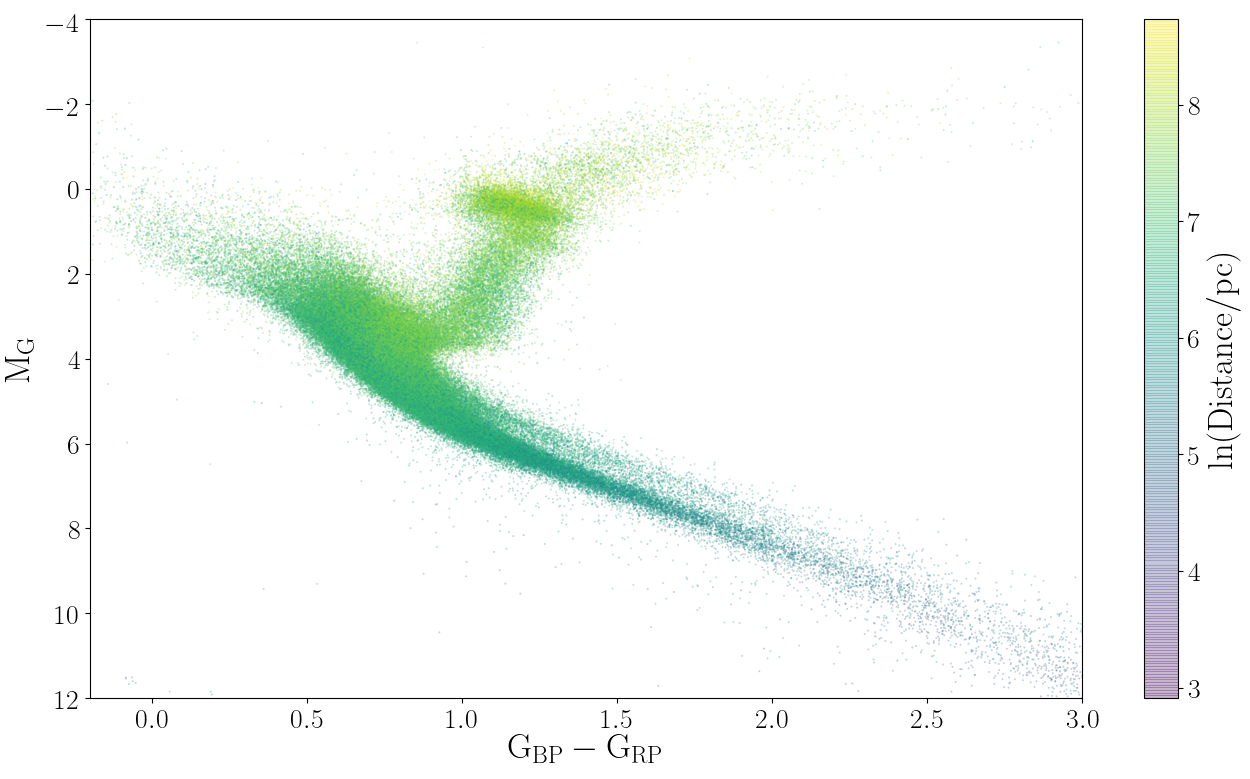

In [42]:
plt.figure(figsize=(16, 9), dpi=100)
plt.scatter(df.bprp_dered, df.abs_G, c=np.log(df.r_est), s=2, alpha=.3, edgecolor="none", zorder=1, rasterized=True)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.colorbar(label="$\ln(\mathrm{Distance/pc})$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

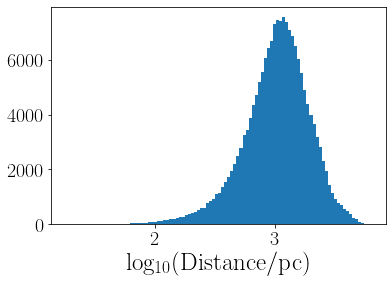

In [43]:
plt.hist(np.log10(df.r_est), 100);
plt.xlabel("$\mathrm{log_{10}(Distance/pc)}$");

# Look at the prior.

In [44]:
import starspot as ss

def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

lnD = np.log(1./df.parallax)
finite = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) \
    & np.isfinite(df.vz.values) & np.isfinite(lnD)

nsigma = 3
mx = ss.sigma_clip(df.vx.values[finite], nsigma=nsigma)
my = ss.sigma_clip(df.vy.values[finite], nsigma=nsigma)
mz = ss.sigma_clip(df.vz.values[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

mu, cov = mean_and_var(df.vx.values[finite][m],
                       df.vy.values[finite][m],
                       df.vz.values[finite][m],
                       lnD[finite][m])

print(np.shape(cov))

(4, 4)


In [45]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [46]:
# cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])

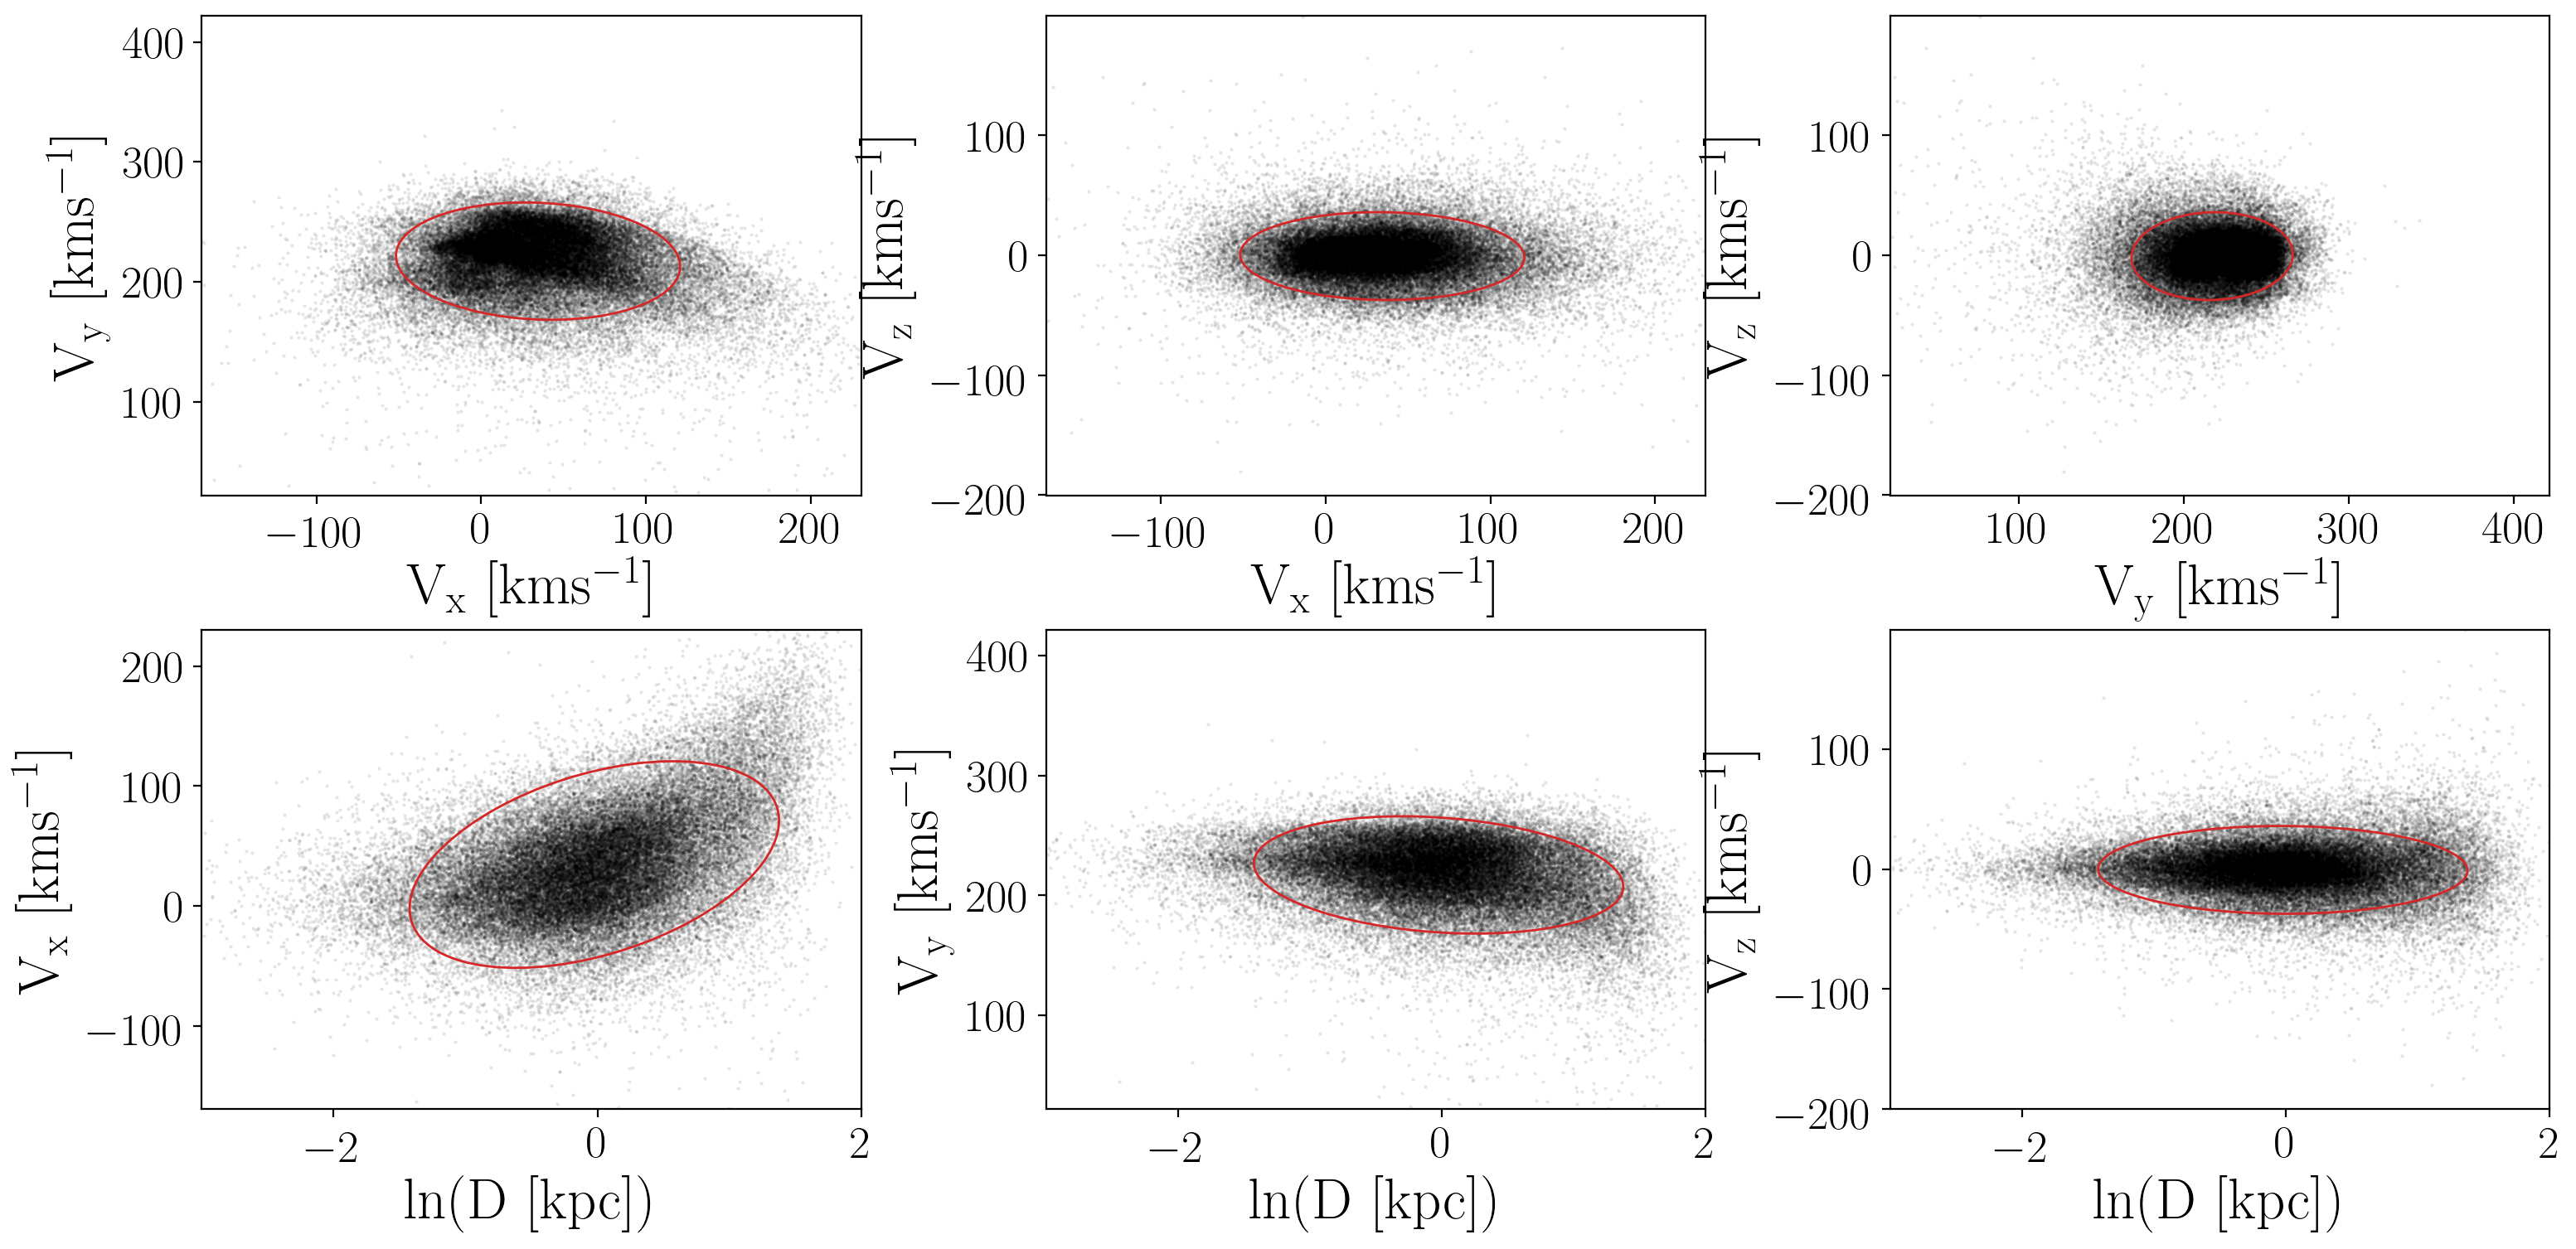

In [47]:
alpha, ms = .1, 1
color = "C3"

box = 200
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx_c, vy_c, vz_c, lnD_c = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.plot(vx_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.plot(lnD_c, vx_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.plot(lnD_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.28)

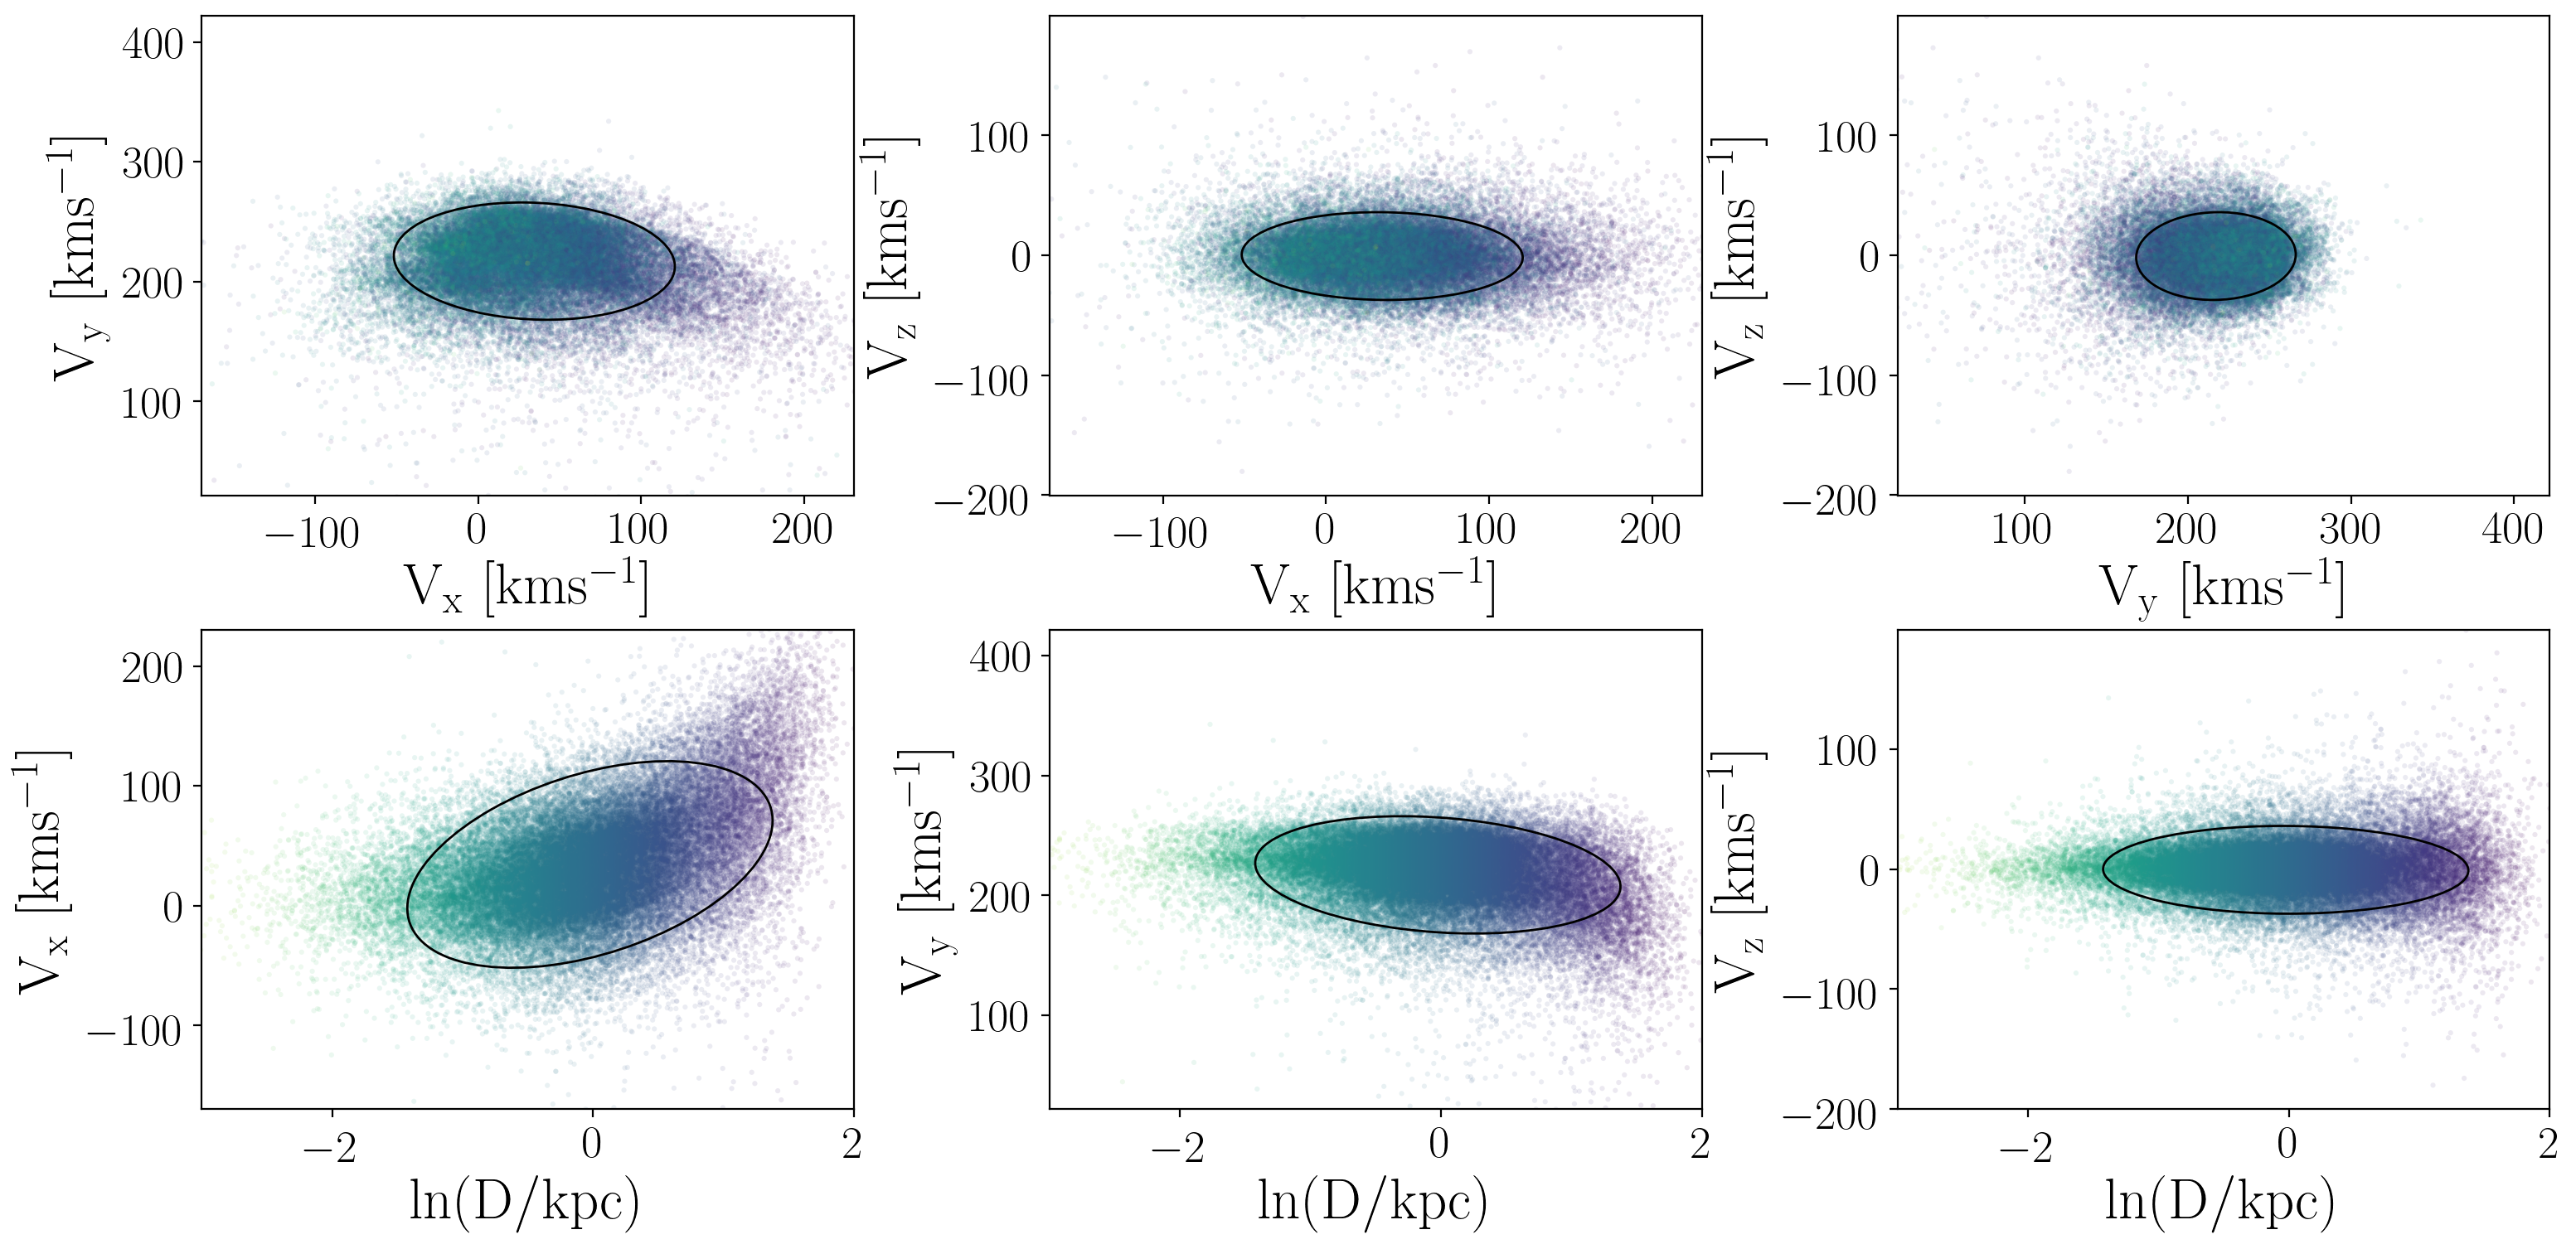

In [48]:
alpha, ms = .1, 1
color = "k"
cmap = "viridis_r"

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.scatter(vx_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.scatter(vx_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.scatter(vy_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.scatter(lnD_c, vx_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.scatter(lnD_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.scatter(lnD_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

# plt.colorbar()
plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.3)

53228 124144


Text(0.5, 0, 'Distance [pc]')

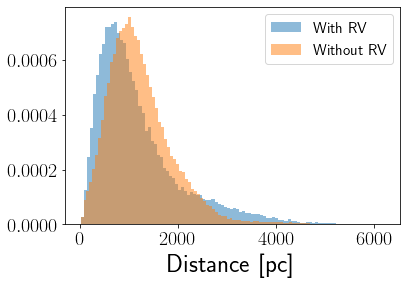

In [49]:
wrv = np.isfinite(df.rv.values) & (df.rv.values != 0)
print(len(df.r_est.values[wrv]), len(df.r_est.values[~wrv]))
plt.hist(df.r_est.values[wrv], 100, density=True, alpha=.5, label="With RV");
plt.hist(df.r_est.values[~wrv], 100, density=True, alpha=.5, label="Without RV");
plt.legend()
# plt.xlim(0, 10)
plt.xlabel("Distance [pc]")

# Take a look at the APOGEE cross match

In [50]:
from astropy.table import Table
tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo = tbl[names].to_pandas()

In [57]:
apo.keys()
# apo.GAIA_SOURCE_ID
[col for col in apo.columns if 'RV' in col]
# [col for col in apo.columns if 'RADIAL_VELOCITY' in col]

['SURVEY',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CCFWHM',
 'RV_AUTOFWHM']

In [61]:
# for k in apo.keys():
#     print(k)
#     OBSVHELIO_AVG, OBSVERR

In [53]:
apodf = pd.merge(apo, df, how="right", left_on="GAIA_SOURCE_ID", right_on="source_id")
apodf = apodf.drop_duplicates(subset="source_id")
print(np.shape(apo), np.shape(df), np.shape(apodf))

(473307, 197) (177372, 151) (177372, 348)
